# *eht-imaging* multifrequency Tutorial

This is a very basic tutorial for multi-frequency imaging that uses complex visibilities, not closure products

In [10]:
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import ehtim as eh
from scipy.ndimage import gaussian_filter
from   ehtim.calibrating import self_cal as sc

# change to 'direct' if you don't have nfft installed
ttype='nfft'

In [7]:
# Load the image and the array
im = eh.image.load_image('../models/avery_sgra_eofn.txt')
eht = eh.array.load_txt('../arrays/EHT2017.txt')

Loading text image:  ../models/avery_sgra_eofn.txt


In [20]:
# Add an artifical spectral index to the image
alpha1 = -2.5
alpha2 = 1

specarr = np.zeros(im.imvec.shape).reshape((im.ydim,im.xdim))
mask = im.imarr() > .5*np.max(im.imvec)
specarr[~mask] = alpha1
specarr[mask] = alpha2
specarr = gaussian_filter(specarr, (4, 4))
im.specvec = specarr.flatten()

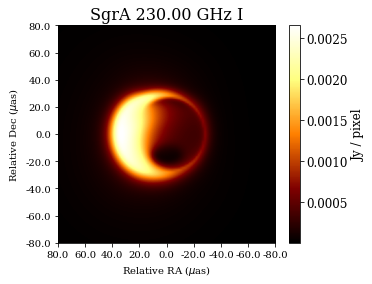

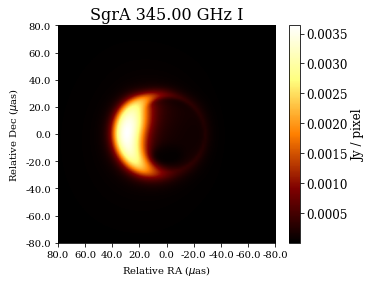

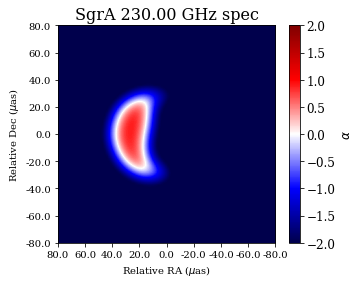

2.4884327618 1.8775344942967283


In [23]:
# display the spectral index
im230 = im.get_image_mf(230.e9)
im345 = im.get_image_mf(345.e9)

im230.display();
im345.display();
im.display(pol='spec',cbar_lims=[-2,2]);
print(im230.total_flux(),im345.total_flux())


In [24]:
# Observe the image at two different frequencies
tint_sec = 60
tadv_sec = 600
tstart_hr = 0
tstop_hr = 24
bw_hz = 2e9
obs230 = im230.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                     sgrscat=False, ampcal=True, phasecal=True)
obs345 = im345.observe(eht, tint_sec, tadv_sec, tstart_hr, tstop_hr, bw_hz,
                        sgrscat=False, ampcal=True, phasecal=True)
obslist = [obs230,obs345]

Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Adding thermal noise to data . . . 
Generating empty observation file . . . 
Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Adding thermal noise to data . . . 


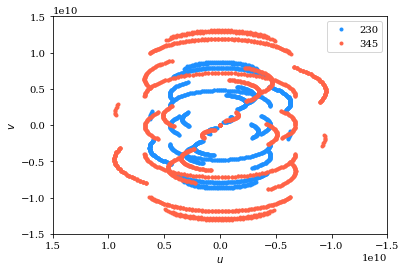

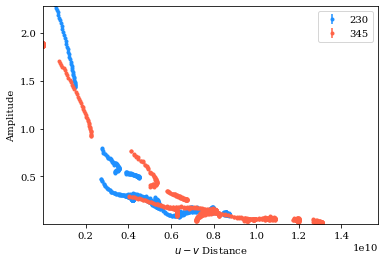

In [25]:
# plot uv-coverage and amplitudes
eh.plotall_obs_compare([obs230,obs345],'u','v',conj=True,rangey=[-1.5e10,1.5e10],rangex=[1.5e10,-1.5e10],legendlabels=['230','345'])
eh.plotall_obs_compare([obs230,obs345],'uvdist','amp',legendlabels=['230','345']);

In [26]:
# Resolution
beamparams230 = obs230.fit_beam() # fitted beam parameters (fwhm_maj, fwhm_min, theta) in radians
res230 = obs230.res() # nominal array resolution, 1/longest baseline
beamparams345 = obs345.fit_beam() # fitted beam parameters (fwhm_maj, fwhm_min, theta) in radians
res345 = obs345.res() # nominal array resolution, 1/longest baseline
print("Nominal Resolution 230 GHz: %.1f uas"%(res230/eh.RADPERUAS))
print("Nominal Resolution 345 GHz: %.1f uas"%(res345/eh.RADPERUAS))

Nominal Resolution 230 GHz: 23.6 uas
Nominal Resolution 345 GHz: 15.8 uas


In [39]:
# Determine zero-baseline spectral index
zbllist = np.array([im230.total_flux(),im345.total_flux()])
rflist = np.array([im230.rf,im345.rf])
alpha0=np.polyfit(np.log(rflist), np.log(zbllist), 1)[0]

In [40]:
# Generate an image prior
npix = 64
fov = 1*im.fovx()
zbl = im.total_flux() # total flux
prior_fwhm = 200*eh.RADPERUAS # Gaussian size in microarcssec
emptyprior = eh.image.make_square(obs230, npix, fov)
flatprior = emptyprior.add_flat(zbl)
gaussprior = emptyprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))

In [41]:
# Image both frequencies together with spectral index using complex visibilities
plt.close('all')
gaussprior = gaussprior.add_const_mf(alpha0) # add an initial constant spectral index

imgr  = eh.imager.Imager(obslist, gaussprior, gaussprior, zbl,
                          data_term={'vis':1},
                          reg_term={'tv':0.05,'l1':0.1,'tv_alpha':0.5},
                          norm_reg=True,
                          epsilon_tv = 1.e-10,
                          mf_which_solve=(1,1,0), #(1,1,0) for spectral index only, (1,1,1) for curvature
                          maxit=100, ttype=ttype)
imgr.make_image_I(mf=True,show_updates=False)
out = imgr.out_last()

for i in range(5): # blur and reimage
    out = out.blur_circ(res230)
    imgr.maxit_next=1000
    imgr.init_next = out
    imgr.make_image_I(mf=True,show_updates=False)
    out = imgr.out_last()


Initializing imager data products . . .
Imager run 1 
Imaging . . .
time: 0.655205 s
J: 27.727287
chi2_vis_0 : 15.33 chi2_vis_1 : 13.24 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
Imaging . . .
time: 6.705995 s
J: 0.948008
chi2_vis_0 : 0.98 chi2_vis_1 : 1.03 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
Imaging . . .
time: 6.622781 s
J: 0.768558
chi2_vis_0 : 0.94 chi2_vis_1 : 1.00 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 4 
Imaging . . .
time: 6.674667 s
J: 0.742038
chi2_vis_0 : 0.94 chi2_vis_1 : 1.00 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 5 
Imaging . . .
time: 6.596329 s
J: 0.728724
chi2_vis_0 : 0.94 chi2_vis_1 : 0.99 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 6 
Imaging . . .
time: 6.610547 s
J: 0.721557
chi2_vis_0 : 0.93 chi2_vis_1 : 0.99 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


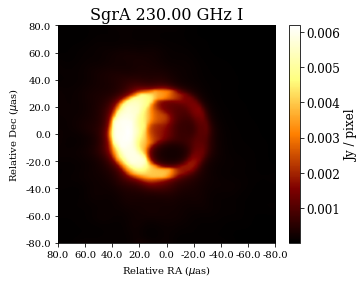

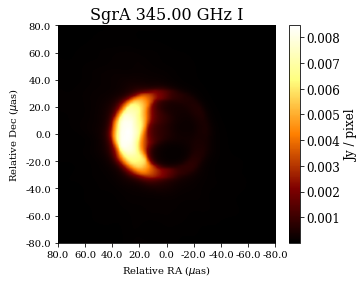

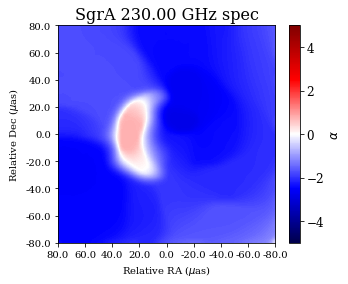

In [43]:
# look at results
out230_mf = out.get_image_mf(230.e9)
out345_mf = out.get_image_mf(345.e9)

out230_mf.display()
out345_mf.display()
out.display(pol='spec');